# Etapa 0: Mesclando Múltiplos Arquivos CSV

In [3]:
%pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 68.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import glob
import os
import time
import requests
from tqdm import tqdm
import pycountry
from babel.core import Locale
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Etapa 0: Mesclando Arquivos CSV ---")

# Pasta onde os arquivos CSV brutos estão localizados.
pasta_dados_brutos = '/content/drive/MyDrive/TCC/Circuitos/'
padrao_arquivos = os.path.join(pasta_dados_brutos, '*.csv')

# Encontra todos os arquivos que correspondem ao padrão
lista_de_arquivos = glob.glob(padrao_arquivos)

df_consolidado = None

if not lista_de_arquivos:
    print(f"Atenção: Nenhum arquivo CSV foi encontrado na pasta '{pasta_dados_brutos}'.")
    print("Por favor, crie a pasta e adicione seus arquivos CSV nela.")
else:
    print(f"Encontrados {len(lista_de_arquivos)} arquivos para mesclar.")

    lista_dataframes = [pd.read_csv(arquivo) for arquivo in lista_de_arquivos]

    # Concatena todos em um único DataFrame
    df_consolidado = pd.concat(lista_dataframes, ignore_index=True)

    print(f"\nArquivos mesclados com sucesso! O DataFrame consolidado possui {len(df_consolidado)} linhas.")

    # Salva o arquivo bruto consolidado para referência
    df_consolidado.to_csv('circuitos_consolidados_brutos.csv', index=False)
    print("Dados brutos consolidados salvos em 'circuitos_consolidados_brutos.csv'.\n")

--- Etapa 0: Mesclando Arquivos CSV ---
Encontrados 2 arquivos para mesclar.

Arquivos mesclados com sucesso! O DataFrame consolidado possui 2060 linhas.
Dados brutos consolidados salvos em 'circuitos_consolidados_brutos.csv'.



# Etapa 1: Limpeza e Tratamento dos Dados

In [5]:
if df_consolidado is not None:
    print("--- Etapa 1: Limpeza e Tratamento dos Dados ---")

    # Usa o DataFrame da etapa anterior
    df_tratado = df_consolidado.copy()

    # --- Ajuste do Timestamp para UTC-3 ---
    df_tratado['timestamp'] = pd.to_datetime(df_tratado['timestamp'], errors='coerce')
    df_tratado.dropna(subset=['timestamp'], inplace=True)
    df_tratado['timestamp'] = df_tratado['timestamp'] - pd.Timedelta(hours=3)
    print("Coluna 'timestamp' ajustada para UTC-3.")

    # --- Remoção de Duplicatas Exatas ---
    linhas_antes = len(df_tratado)
    df_tratado.drop_duplicates(inplace=True)
    linhas_depois = len(df_tratado)
    print(f"{linhas_antes - linhas_depois} linhas duplicadas foram removidas.")

    # Salva o resultado
    df_tratado.to_csv('circuitos_tratados.csv', index=False)
    print("Dados tratados foram salvos em 'circuitos_tratados.csv'.\n")

--- Etapa 1: Limpeza e Tratamento dos Dados ---
Coluna 'timestamp' ajustada para UTC-3.
871 linhas duplicadas foram removidas.
Dados tratados foram salvos em 'circuitos_tratados.csv'.



# Etapa 2: Enriquecimento com Dados de Geolocalização (API)

In [6]:
if 'df_tratado' in locals():
    print("--- Etapa 2: Enriquecimento com Dados da API ---")

    df_enriquecido = df_tratado.copy()
    API_URL = "http://ip-api.com/json/"
    ips_unicos = df_enriquecido['ip'].unique()
    ip_cache = {}

    print(f"Encontrados {len(ips_unicos)} IPs únicos para consultar. Isso pode levar alguns minutos...")

    for ip in tqdm(ips_unicos):
        try:
            response = requests.get(f"{API_URL}{ip}", timeout=5)
            if response.status_code == 200 and response.json().get("status") == "success":
                data = response.json()
                ip_cache[ip] = {'country': data.get('country'), 'asn': data.get('as')}
            else:
                ip_cache[ip] = {'country': 'Falha na API', 'asn': 'Falha na API'}
        except requests.exceptions.RequestException:
            ip_cache[ip] = {'country': 'Erro de Conexão', 'asn': 'Erro de Conexão'}
        time.sleep(1.5) # Pausa para não sobrecarregar a API

    # Preenche as colunas usando o cache
    df_enriquecido['country'] = df_enriquecido['ip'].map(lambda ip: ip_cache.get(ip, {}).get('country'))
    df_enriquecido['asn'] = df_enriquecido['ip'].map(lambda ip: ip_cache.get(ip, {}).get('asn'))

    df_enriquecido.to_csv('circuitos_enriquecidos.csv', index=False)
    print("\nDados enriquecidos foram salvos em 'circuitos_enriquecidos.csv'.\n")

--- Etapa 2: Enriquecimento com Dados da API ---
Encontrados 310 IPs únicos para consultar. Isso pode levar alguns minutos...


100%|██████████| 310/310 [07:52<00:00,  1.52s/it]


Dados enriquecidos foram salvos em 'circuitos_enriquecidos.csv'.



# Etapa 3: Finalização e Tradução

In [7]:
if 'df_enriquecido' in locals():
    print("--- Etapa 3: Finalização e Tradução ---")

    df_final = df_enriquecido.copy()

    # --- Remover a coluna 'bandwidth' ---
    if 'bandwidth' in df_final.columns:
        df_final.drop('bandwidth', axis=1, inplace=True)
        print("Coluna 'bandwidth' removida.")

    # --- Traduzir a coluna 'country' ---
    cache_traducao = {}
    locale_pt_br = Locale('pt', 'BR')

    def traduzir_nome_pais(nome_em_ingles):
        if not isinstance(nome_em_ingles, str): return nome_em_ingles
        if nome_em_ingles in cache_traducao: return cache_traducao[nome_em_ingles]
        try:
            pais_obj = pycountry.countries.search_fuzzy(nome_em_ingles)[0]
            nome_em_portugues = locale_pt_br.territories.get(pais_obj.alpha_2)
            cache_traducao[nome_em_ingles] = nome_em_portugues
            return nome_em_portugues
        except LookupError:
            cache_traducao[nome_em_ingles] = nome_em_ingles
            return nome_em_ingles

    print("Iniciando a tradução dos nomes de países...")
    df_final['country'] = df_final['country'].apply(traduzir_nome_pais)
    print("Tradução concluída.")

    # Salva o DataFrame final, pronto para análise
    df_final.to_csv('circuitos_final_ptbr.csv', index=False, encoding='utf-8-sig')
    print("Arquivo final salvo em 'circuitos_final_ptbr.csv'.\n")

--- Etapa 3: Finalização e Tradução ---
Coluna 'bandwidth' removida.
Iniciando a tradução dos nomes de países...
Tradução concluída.
Arquivo final salvo em 'circuitos_final_ptbr.csv'.



# Etapa 4: Análise Exploratória dos Dados (Visualizações)

--- Etapa 4: Análise Exploratória dos Dados ---
Iniciando a geração dos gráficos...


/tmp/ipython-input-3123054786.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country', data=df_analise, order=df_analise['country'].value_counts().iloc[:15].index, palette='viridis')


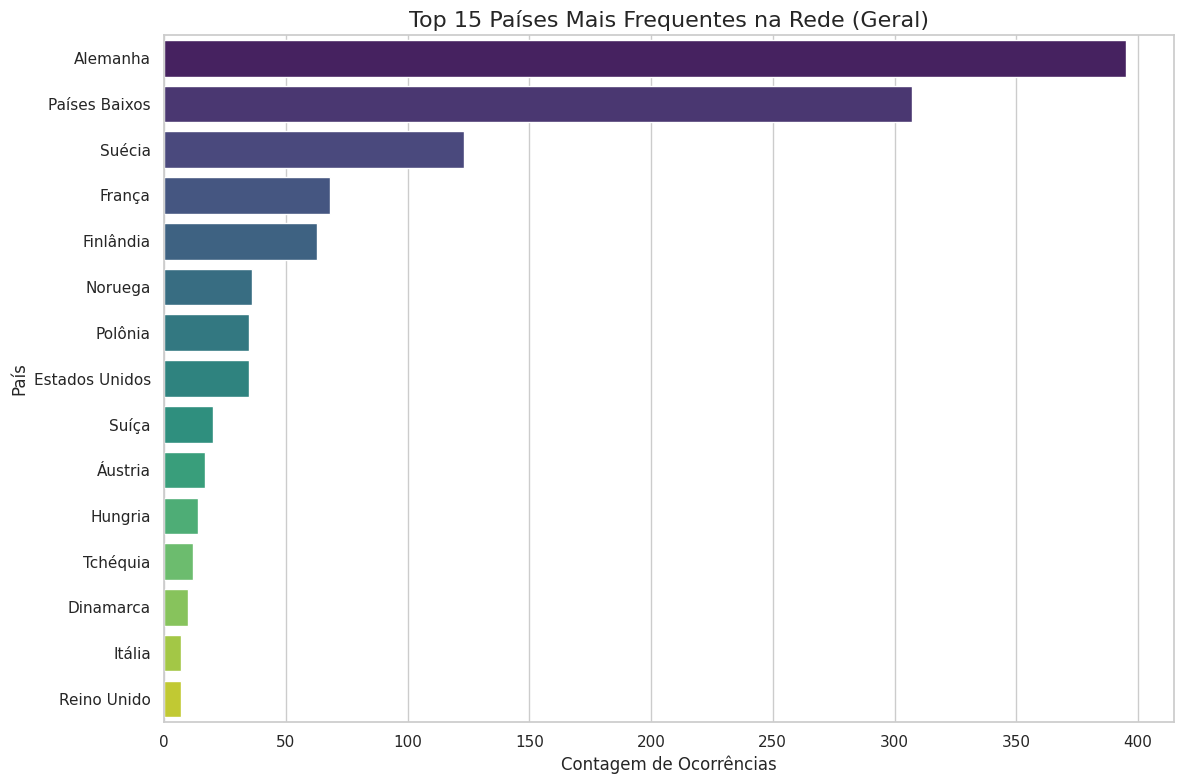

/tmp/ipython-input-3123054786.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country', data=df_guard, order=df_guard['country'].value_counts().iloc[:10].index, ax=axes[0], palette='plasma')
/tmp/ipython-input-3123054786.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country', data=df_middle, order=df_middle['country'].value_counts().iloc[:10].index, ax=axes[1], palette='magma')
/tmp/ipython-input-3123054786.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country', data=df_exit, order=df_exit['country'].value_c

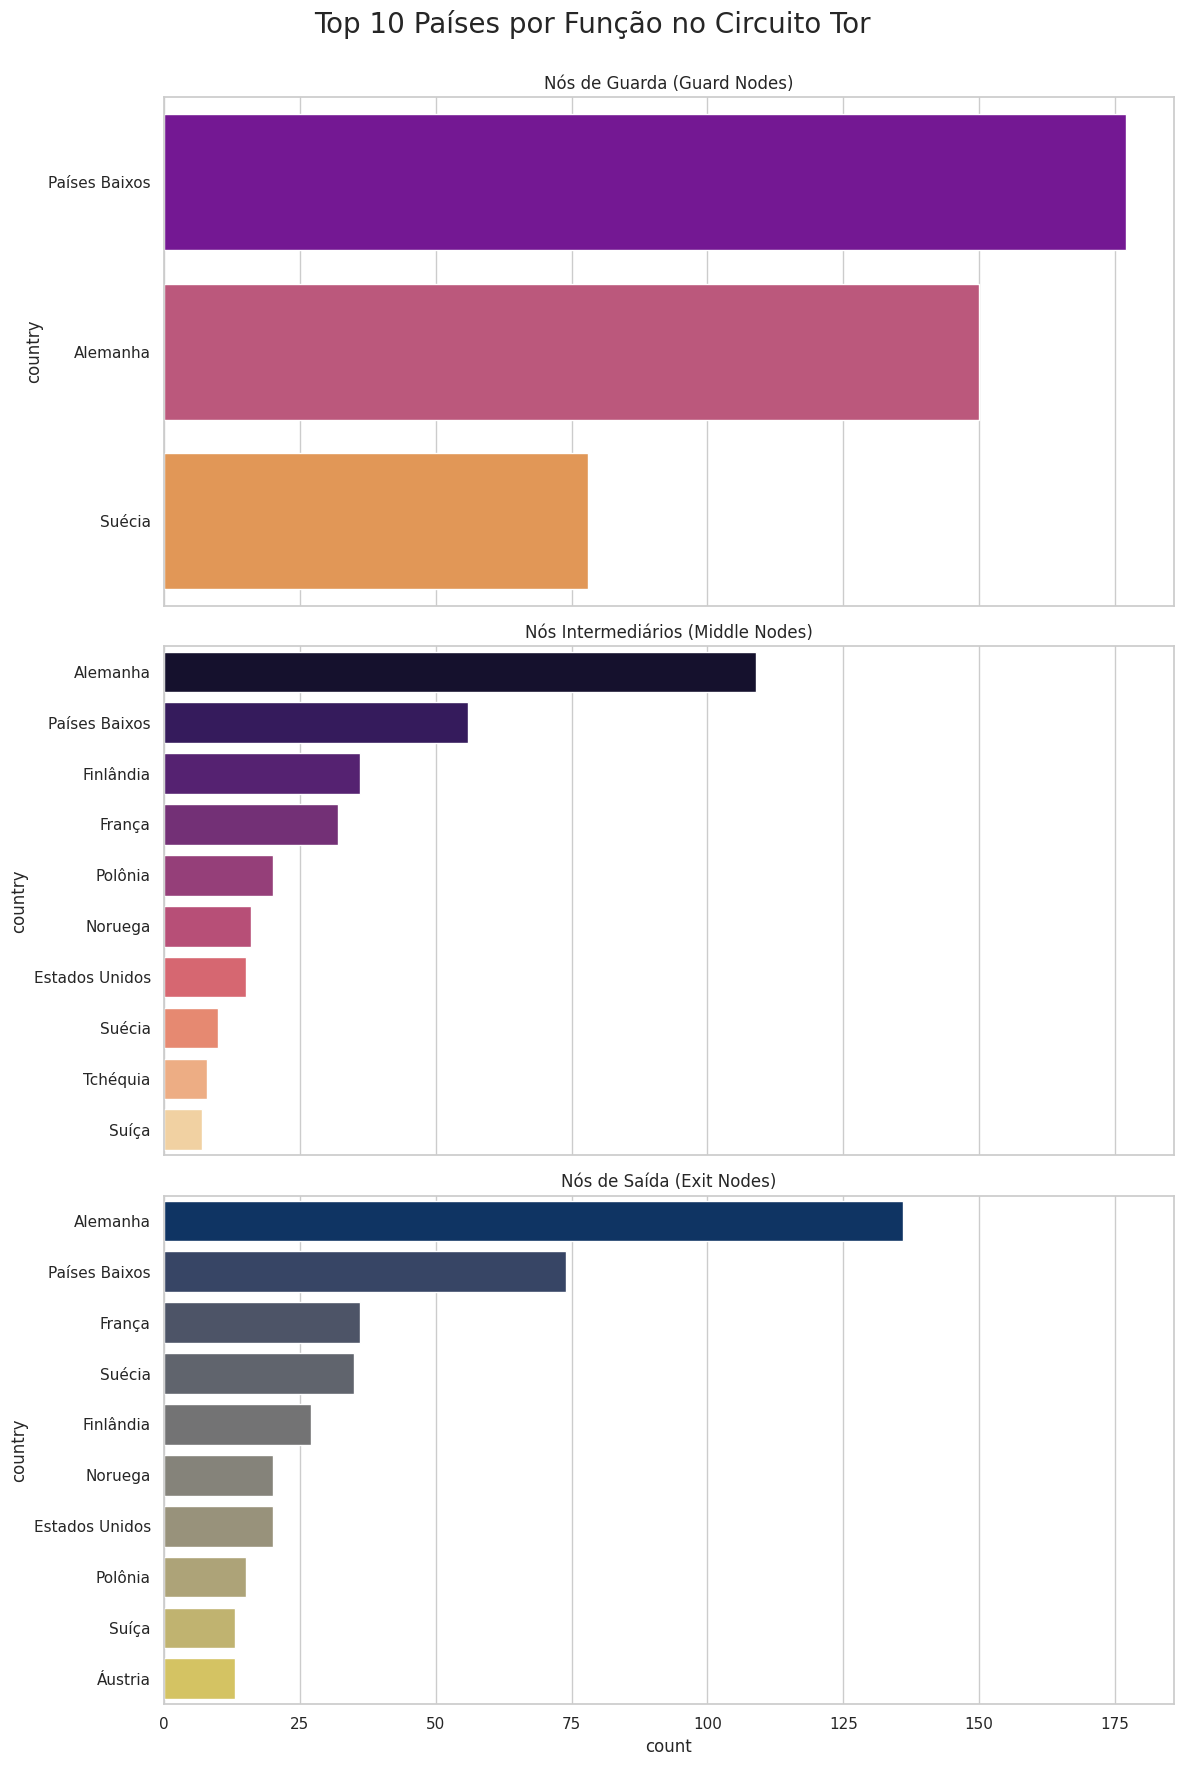

/tmp/ipython-input-3123054786.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='asn', data=df_guard, order=df_guard['asn'].value_counts().iloc[:10].index, ax=axes[0], palette='plasma')
/tmp/ipython-input-3123054786.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='asn', data=df_middle, order=df_middle['asn'].value_counts().iloc[:10].index, ax=axes[1], palette='magma')
/tmp/ipython-input-3123054786.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='asn', data=df_exit, order=df_exit['asn'].value_counts().iloc[:10].index,

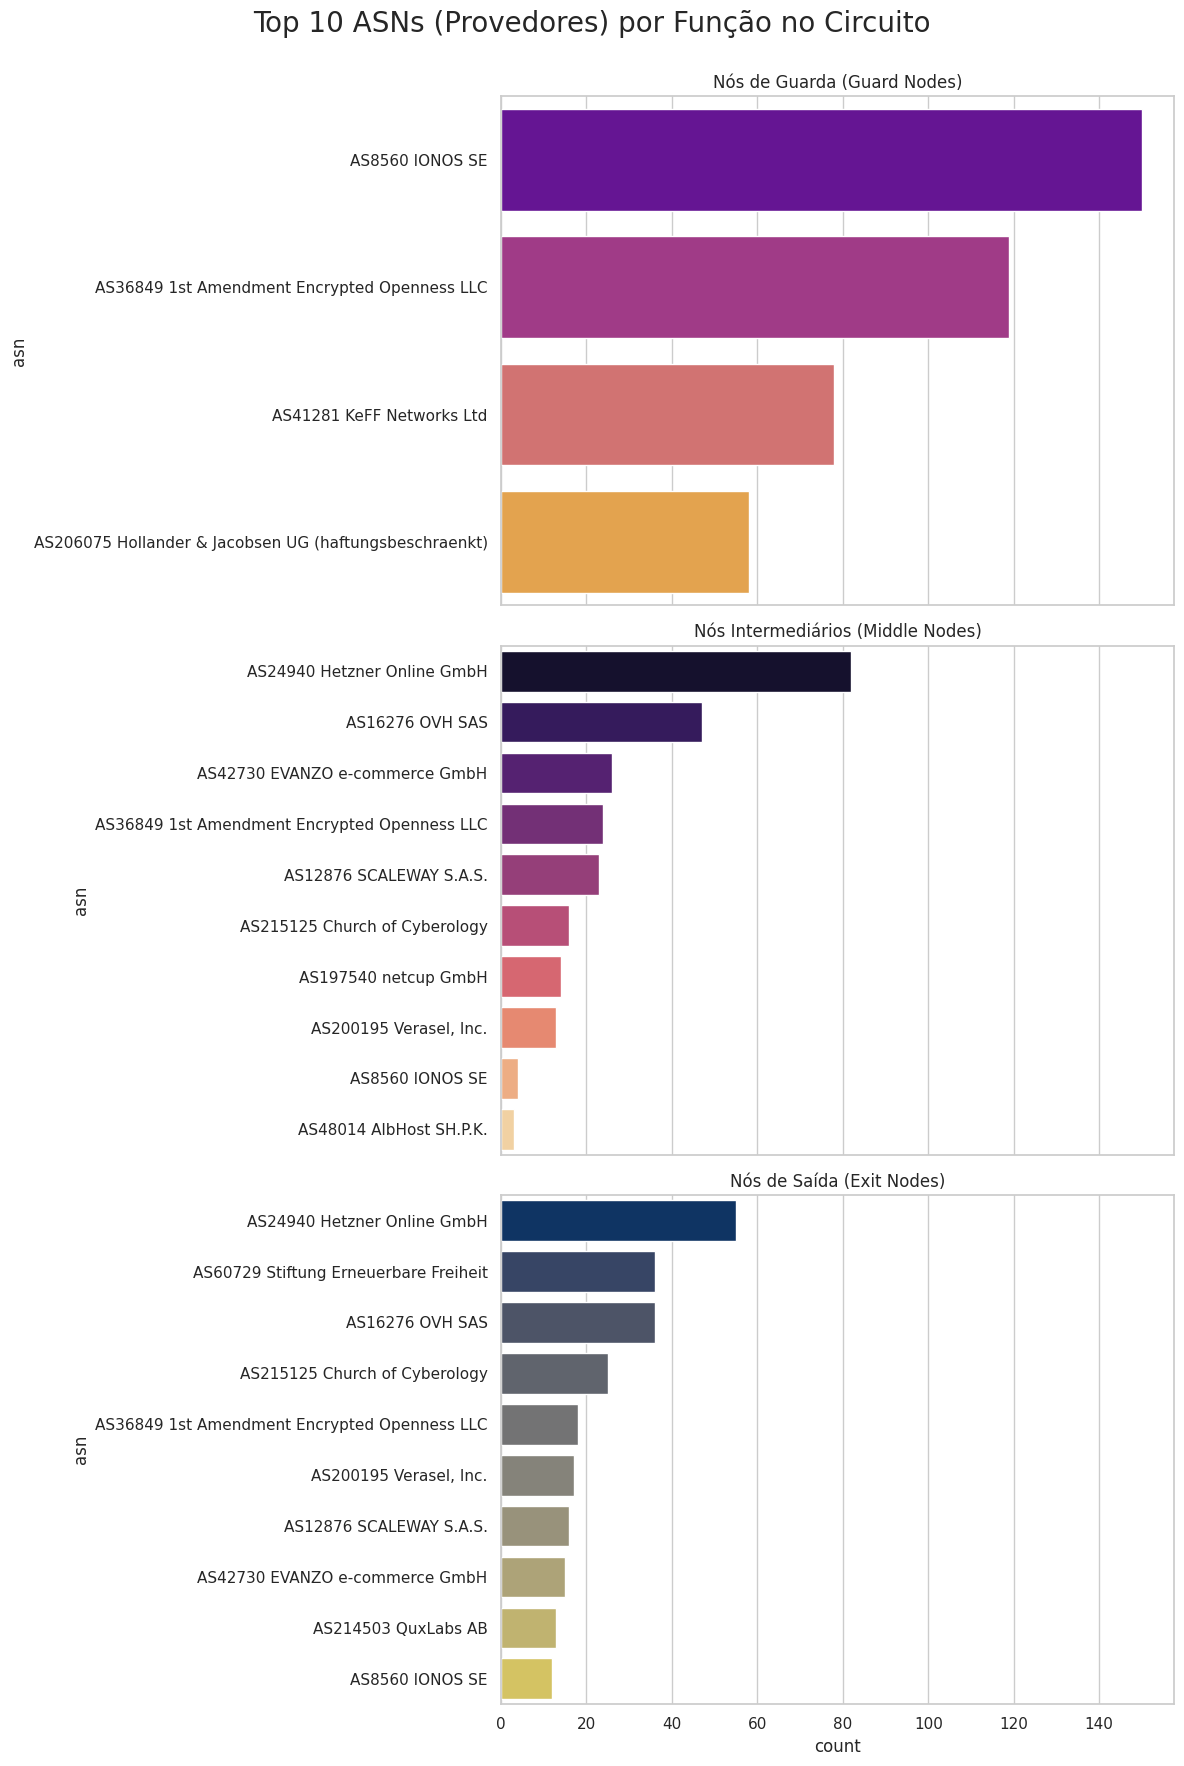


Análise concluída! Os gráficos foram exibidos e salvos como arquivos .png.


In [8]:
print("--- Etapa 4: Análise Exploratória dos Dados ---")
try:
    # Carrega o arquivo final caso precise rodar apenas esta parte do notebook
    df_analise = pd.read_csv('circuitos_final_ptbr.csv')
    df_analise['timestamp'] = pd.to_datetime(df_analise['timestamp'])

    sns.set_theme(style="whitegrid")
    print("Iniciando a geração dos gráficos...")

    # --- Gráfico 1: Top 15 Países (Geral) ---
    plt.figure(figsize=(12, 8))
    sns.countplot(y='country', data=df_analise, order=df_analise['country'].value_counts().iloc[:15].index, palette='viridis')
    plt.title('Top 15 Países Mais Frequentes na Rede (Geral)', fontsize=16)
    plt.xlabel('Contagem de Ocorrências', fontsize=12)
    plt.ylabel('País', fontsize=12)
    plt.tight_layout()
    plt.savefig('grafico_paises_geral.png') # Salva o gráfico
    plt.show()

    # --- Gráfico 2: Top 10 Países por Função ---
    df_guard = df_analise[df_analise['role'] == 'guard']
    df_middle = df_analise[df_analise['role'] == 'middle']
    df_exit = df_analise[df_analise['role'] == 'exit']

    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    fig.suptitle('Top 10 Países por Função no Circuito Tor', fontsize=20)

    sns.countplot(y='country', data=df_guard, order=df_guard['country'].value_counts().iloc[:10].index, ax=axes[0], palette='plasma')
    axes[0].set_title('Nós de Guarda (Guard Nodes)')

    sns.countplot(y='country', data=df_middle, order=df_middle['country'].value_counts().iloc[:10].index, ax=axes[1], palette='magma')
    axes[1].set_title('Nós Intermediários (Middle Nodes)')

    sns.countplot(y='country', data=df_exit, order=df_exit['country'].value_counts().iloc[:10].index, ax=axes[2], palette='cividis')
    axes[2].set_title('Nós de Saída (Exit Nodes)')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('grafico_paises_por_funcao.png') # Salva o gráfico
    plt.show()

    # --- Gráfico 3: Top 10 ASNs por Função ---
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    fig.suptitle('Top 10 ASNs (Provedores) por Função no Circuito', fontsize=20)

    sns.countplot(y='asn', data=df_guard, order=df_guard['asn'].value_counts().iloc[:10].index, ax=axes[0], palette='plasma')
    axes[0].set_title('Nós de Guarda (Guard Nodes)')

    sns.countplot(y='asn', data=df_middle, order=df_middle['asn'].value_counts().iloc[:10].index, ax=axes[1], palette='magma')
    axes[1].set_title('Nós Intermediários (Middle Nodes)')

    sns.countplot(y='asn', data=df_exit, order=df_exit['asn'].value_counts().iloc[:10].index, ax=axes[2], palette='cividis')
    axes[2].set_title('Nós de Saída (Exit Nodes)')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('grafico_asn_por_funcao.png') # Salva o gráfico
    plt.show()

    print("\nAnálise concluída! Os gráficos foram exibidos e salvos como arquivos .png.")

except FileNotFoundError:
    print("Erro: O arquivo 'circuitos_final_ptbr.csv' não foi encontrado. Execute as etapas anteriores primeiro.")
except Exception as e:
    print(f"Ocorreu um erro durante a análise: {e}")

# Etapa 5: Análise Exploratória e Avançada

--- Etapa 4: Análise Exploratória e Avançada ---
Iniciando a geração de análises e gráficos...

Gerando gráficos de frequência...


/tmp/ipython-input-1244661412.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country', data=df, order=df['country'].value_counts().iloc[:15].index, palette='viridis')


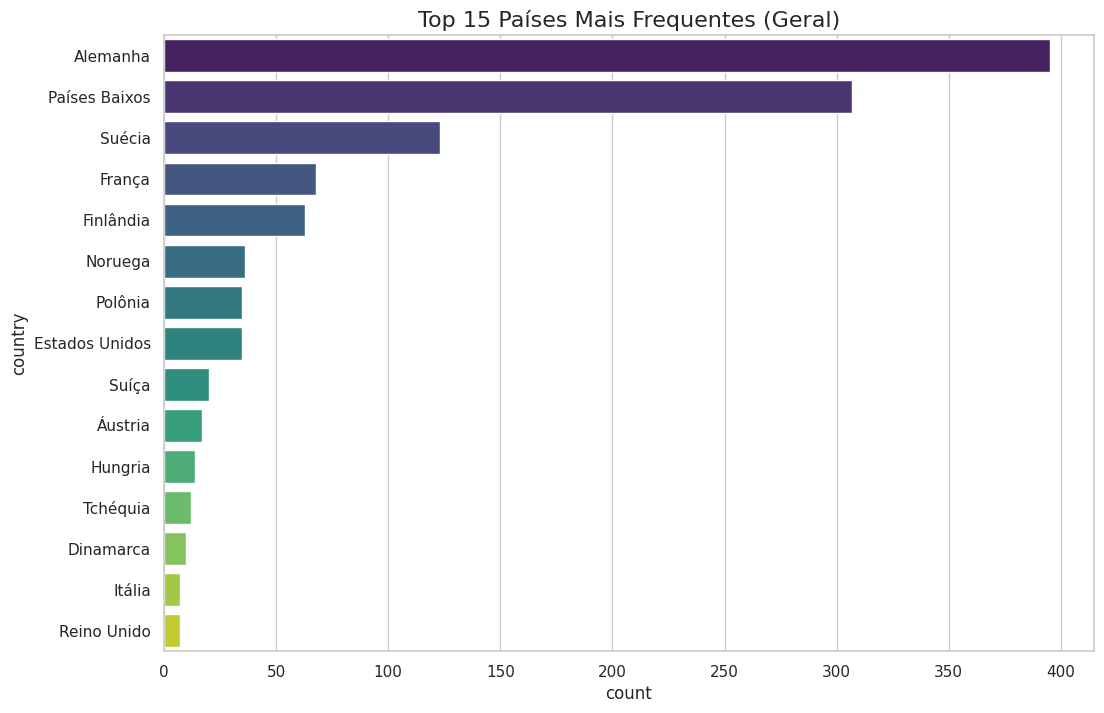


Preparando dados para análise de circuitos completos...
Encontrados 70 circuitos completos para análise avançada.

Executando Análise de Risco de Segurança...
-> Porcentagem de circuitos com Guard e Exit no MESMO ASN: 1.43%
-> Porcentagem de circuitos com Guard e Exit no MESMO País: 21.43%

Analisando as trilhas de circuitos mais comuns...

Top 10 Trilhas de Países (Guard -> Middle -> Exit):
country_guard  country_middle  country_exit  
Alemanha       Alemanha        Suécia            4
Países Baixos  Alemanha        Países Baixos     4
Alemanha       Alemanha        Alemanha          3
               Países Baixos   Países Baixos     3
Países Baixos  Alemanha        Alemanha          3
Alemanha       França          Alemanha          2
               Alemanha        Países Baixos     2
Países Baixos  Alemanha        Estados Unidos    2
Alemanha       Bélgica         Polônia           1
               Estados Unidos  Suécia            1
Name: count, dtype: int64

Top 10 Trilhas de ASN

/tmp/ipython-input-1244661412.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=asn_dist.values, y=asn_dist.index, palette='magma')


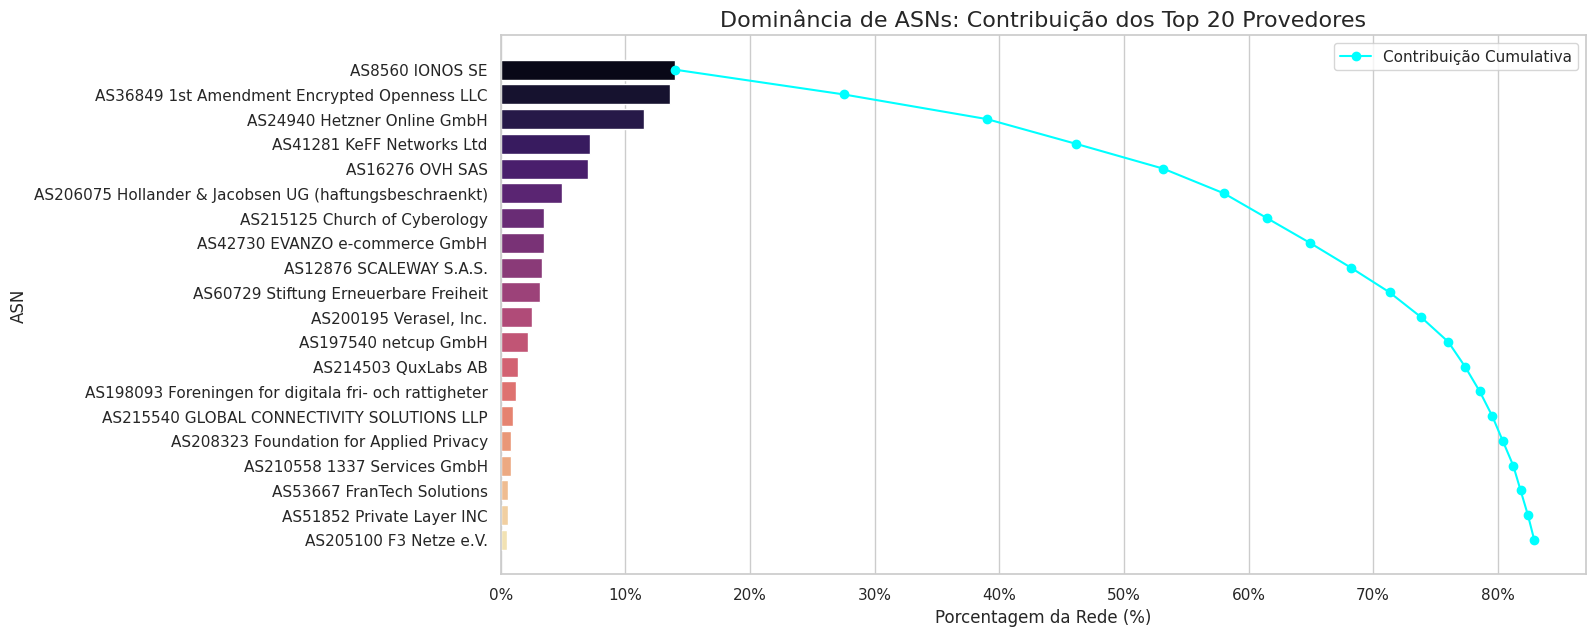

Os 5 ASNs mais comuns controlam 53.15% da rede observada.
Os 10 ASNs mais comuns controlam 71.32% da rede observada.

Executando Análise Temporal...
Dados cobrem apenas um dia. Gráfico de evolução temporal não gerado.

--- Análise Completa Finalizada ---


In [9]:
print("--- Etapa 4: Análise Exploratória e Avançada ---")
try:
    df = pd.read_csv('circuitos_final_ptbr.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    sns.set_theme(style="whitegrid")
    print("Iniciando a geração de análises e gráficos...")

    # --- 4.1 Análise de Frequência (Gráficos Básicos) ---
    print("\nGerando gráficos de frequência...")
    plt.figure(figsize=(12, 8))
    sns.countplot(y='country', data=df, order=df['country'].value_counts().iloc[:15].index, palette='viridis')
    plt.title('Top 15 Países Mais Frequentes (Geral)', fontsize=16)
    plt.savefig('grafico_paises_geral.png')
    plt.show()

    # --- 4.2 Preparação para Análises Avançadas: Pivotando os Dados ---
    print("\nPreparando dados para análise de circuitos completos...")
    # Precisamos dos últimos 3 nós de cada circuito_id para formar o caminho completo
    df_circuitos_completos = df.groupby('circuit_id').tail(3)

    # Pivotando para ter guard, middle e exit como colunas
    df_pivot = df_circuitos_completos.pivot_table(
        index='circuit_id',
        columns='role',
        values=['country', 'asn'],
        aggfunc='first'
    )
    # Limpando os nomes das colunas (ex: de ('country', 'guard') para 'country_guard')
    df_pivot.columns = [f'{col[0]}_{col[1]}' for col in df_pivot.columns]
    df_pivot.dropna(inplace=True) # Garante que só analisaremos circuitos com 3 nós
    print(f"Encontrados {len(df_pivot)} circuitos completos para análise avançada.")

    # --- 4.3 Análise de Risco de Segurança (End-to-End Correlation) ---
    print("\nExecutando Análise de Risco de Segurança...")
    mesmo_asn = df_pivot[df_pivot['asn_guard'] == df_pivot['asn_exit']]
    perc_risco_asn = (len(mesmo_asn) / len(df_pivot)) * 100
    print(f"-> Porcentagem de circuitos com Guard e Exit no MESMO ASN: {perc_risco_asn:.2f}%")

    mesmo_pais = df_pivot[df_pivot['country_guard'] == df_pivot['country_exit']]
    perc_risco_pais = (len(mesmo_pais) / len(df_pivot)) * 100
    print(f"-> Porcentagem de circuitos com Guard e Exit no MESMO País: {perc_risco_pais:.2f}%")

    # --- 4.4 Análise da Composição dos Circuitos Completos ---
    print("\nAnalisando as trilhas de circuitos mais comuns...")
    trilhas_paises = df_pivot[['country_guard', 'country_middle', 'country_exit']].value_counts().head(10)
    print("\nTop 10 Trilhas de Países (Guard -> Middle -> Exit):")
    print(trilhas_paises)

    trilhas_asns = df_pivot[['asn_guard', 'asn_middle', 'asn_exit']].value_counts().head(10)
    print("\nTop 10 Trilhas de ASNs (Guard -> Middle -> Exit):")
    print(trilhas_asns)

    # --- 4.5 Análise de Centralização e Dominância ---
    print("\nExecutando Análise de Centralização...")
    plt.figure(figsize=(14, 7))
    # Calcula a porcentagem de contribuição de cada ASN
    asn_dist = df['asn'].value_counts(normalize=True).iloc[:20]
    sns.barplot(x=asn_dist.values, y=asn_dist.index, palette='magma')
    # Calcula e plota a linha de contribuição cumulativa
    cumulative_perc = asn_dist.cumsum()
    plt.plot(cumulative_perc.values, cumulative_perc.index, color='cyan', marker='o', label='Contribuição Cumulativa')
    plt.title('Dominância de ASNs: Contribuição dos Top 20 Provedores', fontsize=16)
    plt.xlabel('Porcentagem da Rede (%)')
    plt.ylabel('ASN')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    plt.savefig('grafico_dominancia_asn.png')
    plt.show()
    print(f"Os 5 ASNs mais comuns controlam {cumulative_perc.iloc[4]:.2%} da rede observada.")
    print(f"Os 10 ASNs mais comuns controlam {cumulative_perc.iloc[9]:.2%} da rede observada.")

    # --- 4.6 Análise Temporal ---
    print("\nExecutando Análise Temporal...")
    # Define o timestamp como índice para facilitar o agrupamento
    df.set_index('timestamp', inplace=True)
    # Agrupa por dia e conta o número de países únicos
    diversidade_diaria = df.resample('D')['country'].nunique()

    if len(diversidade_diaria) > 1:
        plt.figure(figsize=(12, 6))
        diversidade_diaria.plot(marker='o', linestyle='-')
        plt.title('Evolução da Diversidade de Países na Rede por Dia', fontsize=16)
        plt.ylabel('Número de Países Únicos')
        plt.xlabel('Data')
        plt.grid(True)
        plt.savefig('grafico_diversidade_temporal.png')
        plt.show()
    else:
        print("Dados cobrem apenas um dia. Gráfico de evolução temporal não gerado.")

    print("\n--- Análise Completa Finalizada ---")

except FileNotFoundError:
    print("Erro: 'circuitos_final_ptbr.csv' não encontrado. Execute as etapas anteriores.")
except Exception as e:
    print(f"Ocorreu um erro durante a análise: {e}")

#